# Part 2. Topic analysis of positive and negative comments using LDA models

In [1]:
import os
import csv
import warnings
import time

import numpy as np
import matplotlib.pyplot as plt

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis.gensim

from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')

## 1. Calculation of the optimal number of topics

### Function Design : Use Perplexity and Coherence 

In [2]:
def plot_perplexity(num_topics_range, perplexity_values, save_dir, file_name):
    plt.plot(num_topics_range, perplexity_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    plt.title('Perplexity vs Number of Topics')
    plt.savefig(os.path.join(save_dir, file_name))
    plt.show()
    plt.close()

def plot_coherence_scores(num_topics_range, coherence_scores, save_dir, file_name):
    plt.plot(num_topics_range, coherence_scores)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence Score vs Number of Topics')
    plt.savefig(os.path.join(save_dir, file_name))
    plt.show()
    plt.close()

def get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir):
    '''
    Compute the optimal number of topics.

    Parameters:
    file_path: str, the file path of the preprocessed text file.
    num_topics_range: list, the range of topic numbers to try.
    save_dir: str, the directory path to save the generated plots.

    Returns:
    best_num_topics: int, the optimal number of topics.
    '''

    # Read the file and create the corpus
    with open(file_path, 'r', encoding='utf-8') as f:
        corpus = [line.strip().split() for line in f]

    # Create the dictionary
    dictionary = Dictionary(corpus)

    # Train the LDA models with different topic numbers, and calculate the perplexity values
    perplexity_values = []
    lda_models = []
    for num_topics in num_topics_range:
        lda_model = LdaModel(corpus=[dictionary.doc2bow(text) for text in corpus], id2word=dictionary, num_topics=num_topics)
        lda_models.append(lda_model)
        perplexity_values.append(lda_model.log_perplexity([dictionary.doc2bow(text) for text in corpus]))

    # Generate unique file names based on current timestamp
    timestamp = str(time.time()).replace('.', '')  # Unique timestamp
    perplexity_file_name = f'perplexity_plot_{timestamp}.svg'
    coherence_file_name = f'coherence_plot_{timestamp}.svg'

    # Save the perplexity plot and coherence plot as vector images
    plot_perplexity(num_topics_range, perplexity_values, save_dir, perplexity_file_name)

    # Calculate the coherence scores using the perplexity values
    coherence_scores = [CoherenceModel(model=lda_model, texts=corpus, dictionary=dictionary, coherence='c_v').get_coherence() for lda_model in lda_models]

    # Save the coherence plot as a vector image
    plot_coherence_scores(num_topics_range, coherence_scores, save_dir, coherence_file_name)

    # Find the optimal number of topics based on the coherence scores
    best_num_topics_index = coherence_scores.index(max(coherence_scores))
    best_num_topics = num_topics_range[best_num_topics_index]
    
    print("Optimal number of topics (using perplexity method):", best_num_topics)

    return best_num_topics

### Function Design : Use Cosine_Similarity

In [3]:
def plot_similarity(num_topics_range, similarity_values, save_dir, file_name):
    plt.plot(num_topics_range, similarity_values)
    plt.xlabel('Number of Topics')
    plt.ylabel('Average Cosine Similarity')
    plt.title('Average Cosine Similarity vs Number of Topics')
    plt.savefig(os.path.join(save_dir, file_name))
    plt.show()
    plt.close()

def get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir):
    '''
    Compute the optimal number of topics.

    Parameters:
    file_path: str, the file path of the preprocessed text file.
    num_topics_range: list, the range of topic numbers to try.
    save_dir: str, the directory path to save the generated plots.

    Returns:
    best_num_topics: int, the optimal number of topics.
    '''

    # Read file and create corpus
    with open(file_path, 'r', encoding='utf-8') as f:
        corpus = [line.strip().split() for line in f]

    # Create dictionary
    dictionary = gensim.corpora.Dictionary(corpus)

    # Train LDA model and compute cosine similarity between topics for different number of topics
    similarity_values = []
    for num_topics in num_topics_range:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=[dictionary.doc2bow(text) for text in corpus], id2word=dictionary, num_topics=num_topics)
        topics_matrix = lda_model.get_topics()
        cosine_similarities = cosine_similarity(topics_matrix)
        similarity_values.append(np.mean(cosine_similarities[np.triu_indices(num_topics, k=1)]))

    # Generate a unique file name based on current timestamp
    timestamp = str(time.time()).replace('.', '')  # Unique timestamp
    file_name = f'similarity_plot_{timestamp}.svg'

    # Save the similarity plot as a vector image
    plot_similarity(num_topics_range, similarity_values, save_dir, file_name)

    # Find the optimal number of topics
    best_num_topics_index = similarity_values.index(min(similarity_values))
    best_num_topics = num_topics_range[best_num_topics_index]
    
    print("Optimal number of topics (using cosine similarity method):", best_num_topics)
    
    return best_num_topics

### Call the function to output the respective optimal number of topics

In [4]:
# Create a list of integers for the range of number of topics.
num_topics_range = list(range(2, 10, 2))

# Set the path to save the vector image
save_dir = "../images/Optimal_topics_number_search"

# Assign weights to each variable
weight_perplexity = 0.7
weight_similarity = 0.3

#### For stores 1

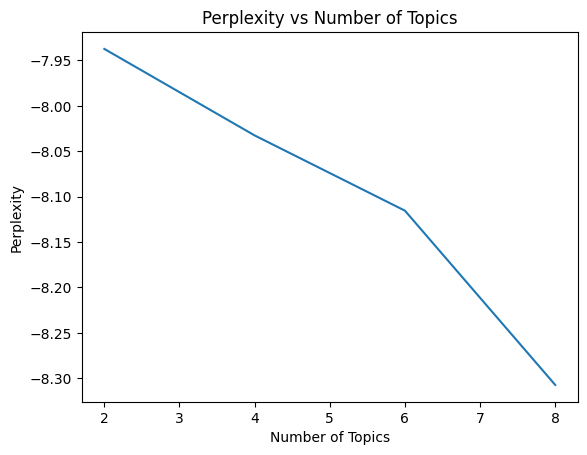

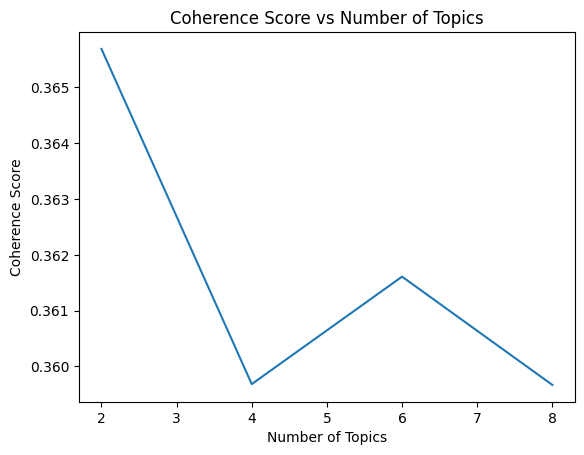

Optimal number of topics (using perplexity method): 2


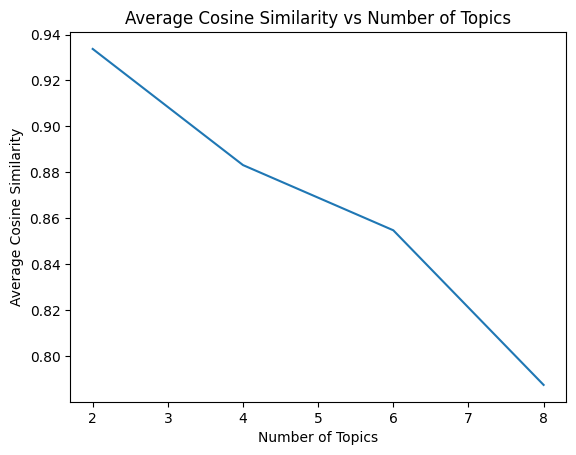

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 3


In [5]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_1_polarity_P.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
P1_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", P1_best_num_topics)

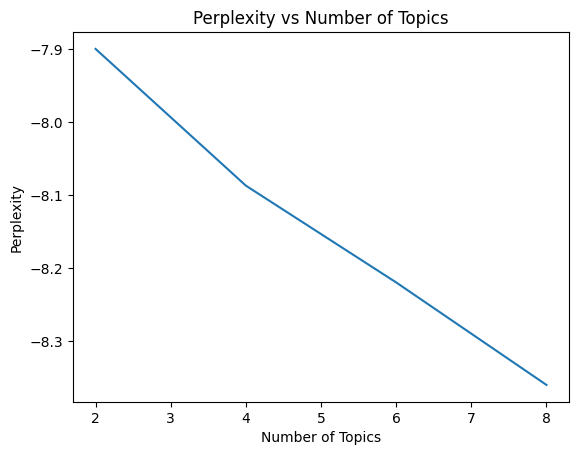

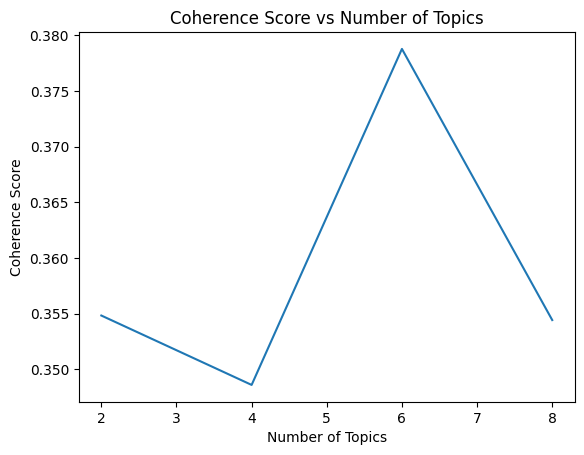

Optimal number of topics (using perplexity method): 6


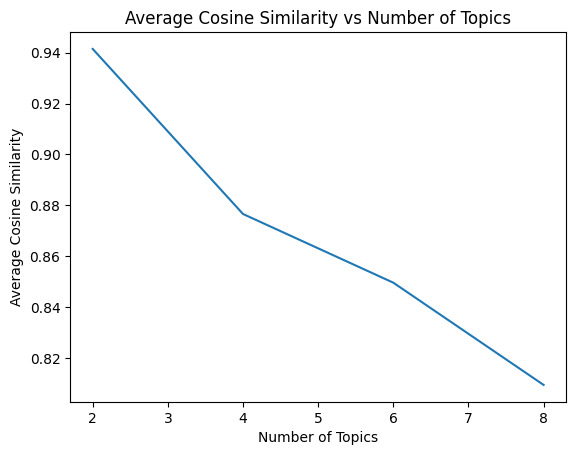

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 6


In [6]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_1_polarity_N.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
N1_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", N1_best_num_topics)

#### For stores 2

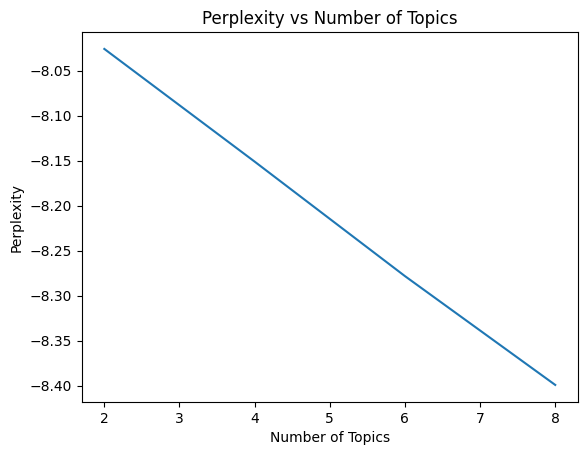

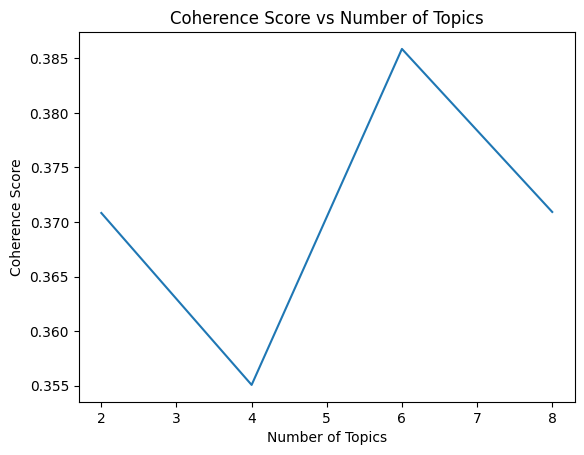

Optimal number of topics (using perplexity method): 6


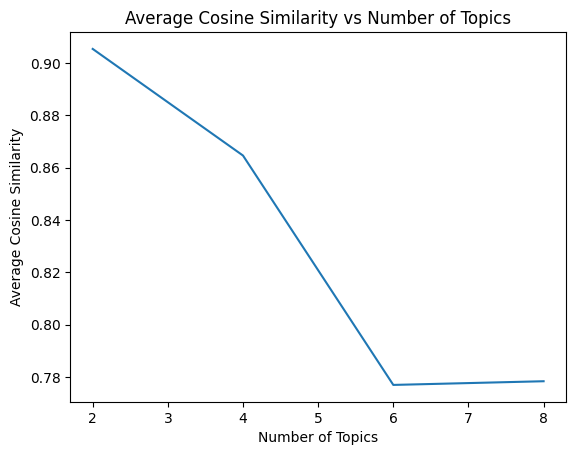

Optimal number of topics (using cosine similarity method): 6
Ultimate optimal number of topics : 5


In [7]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_2_polarity_P.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
P2_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", P2_best_num_topics)

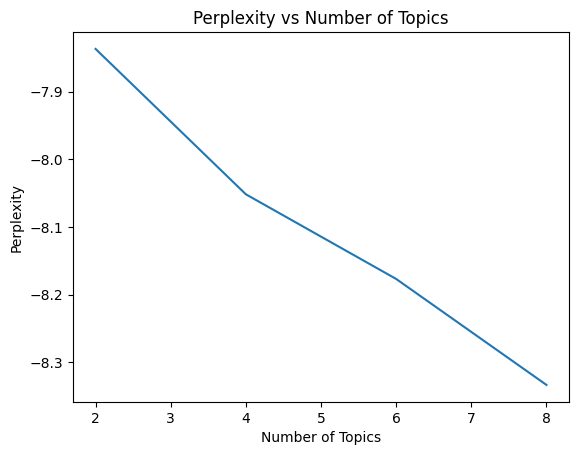

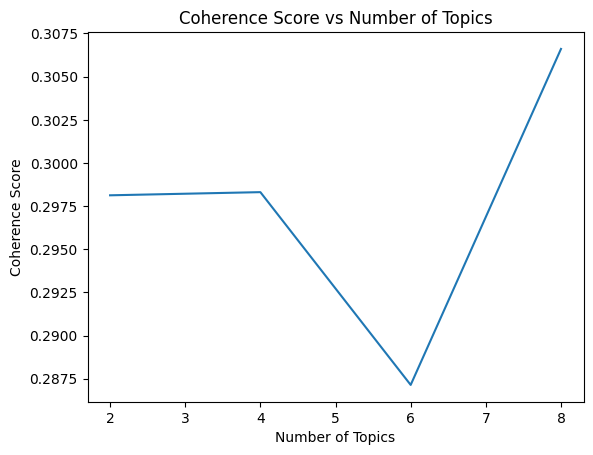

Optimal number of topics (using perplexity method): 8


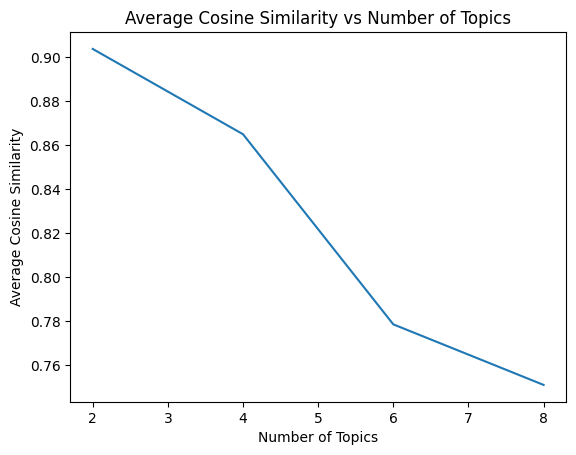

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 8


In [8]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_2_polarity_N.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
N2_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", N2_best_num_topics)

#### For stores 3

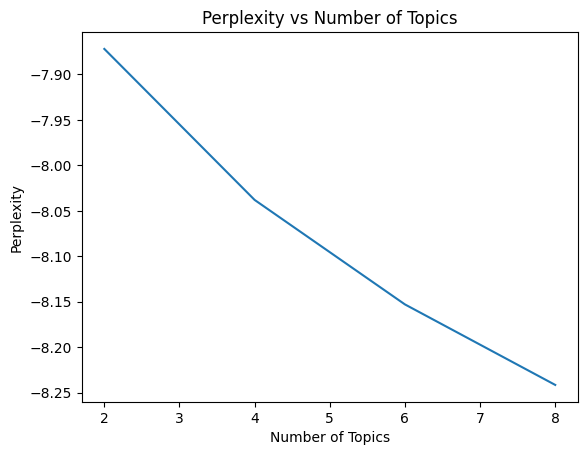

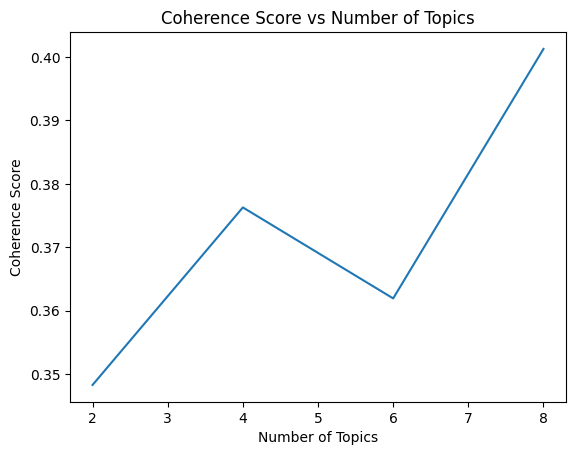

Optimal number of topics (using perplexity method): 8


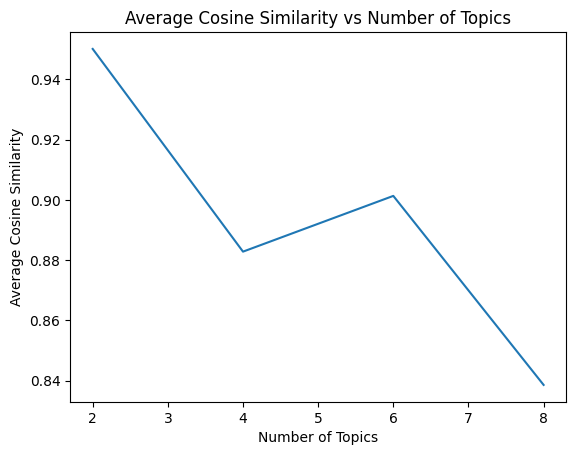

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 8


In [9]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_3_polarity_P.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
P3_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", P3_best_num_topics)

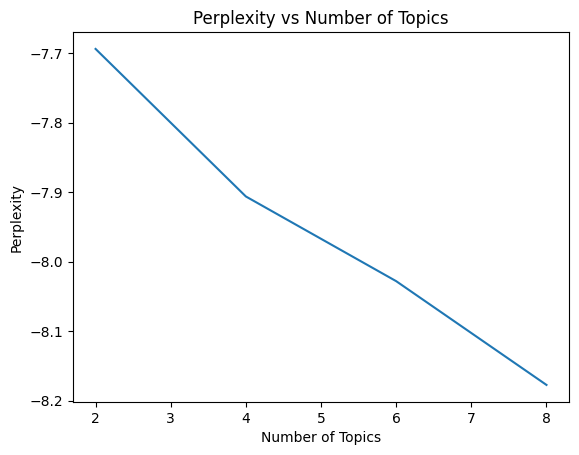

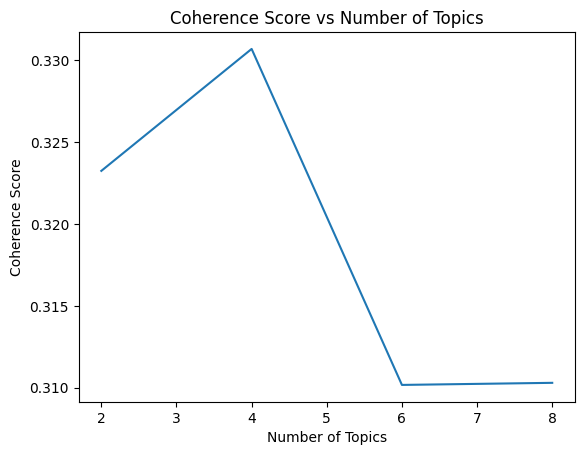

Optimal number of topics (using perplexity method): 4


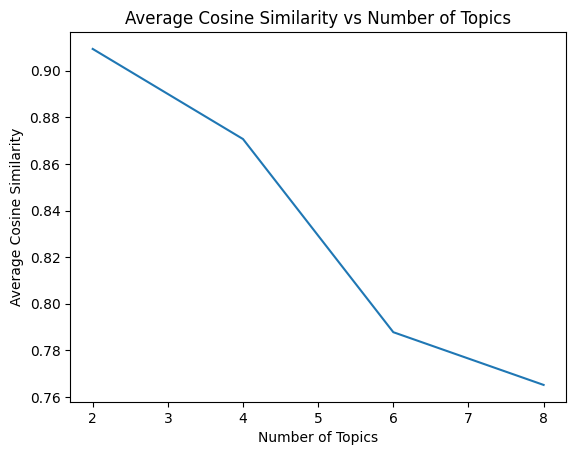

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 5


In [10]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_3_polarity_N.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
N3_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", N3_best_num_topics)

#### For stores 4

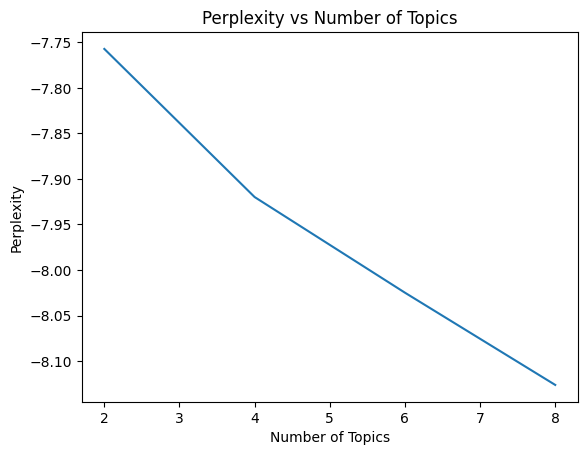

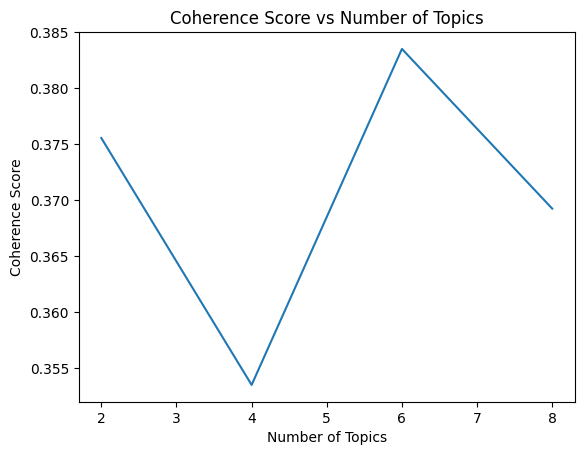

Optimal number of topics (using perplexity method): 6


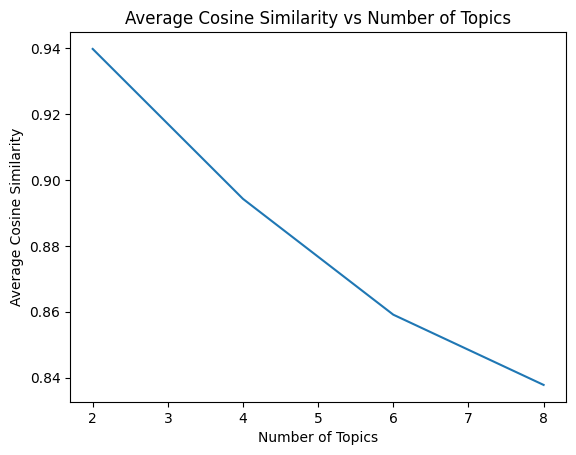

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 6


In [11]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_4_polarity_P.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
P4_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", P4_best_num_topics)

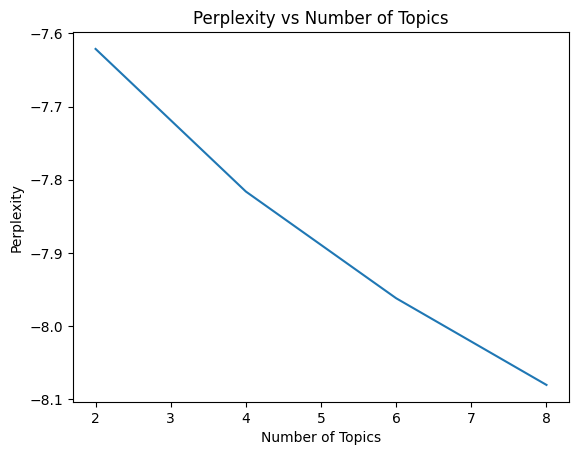

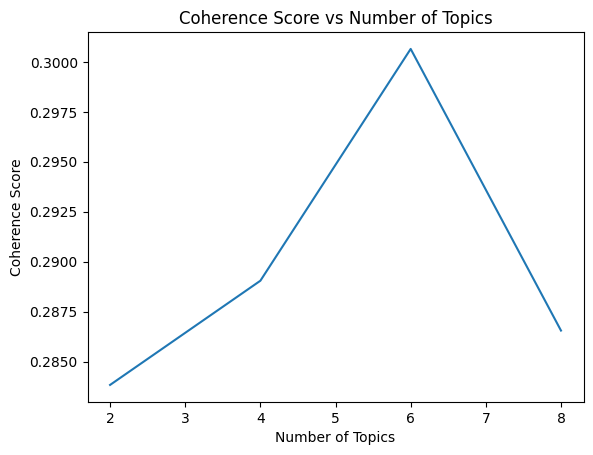

Optimal number of topics (using perplexity method): 6


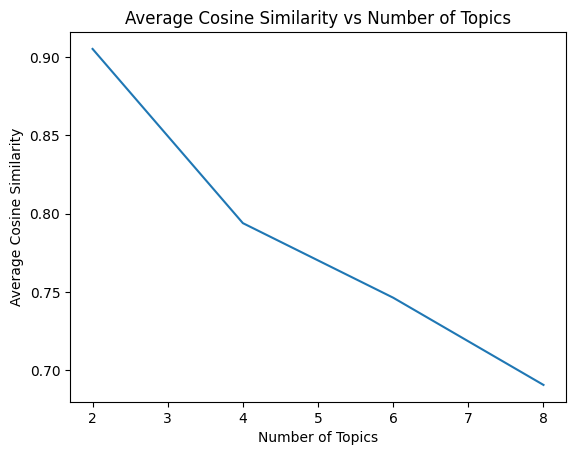

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 6


In [12]:
# Set the file path for a text file.
file_path = "../data/review/analysis/polarity/reviews_4_polarity_N.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
N4_best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", N4_best_num_topics)

## 2. Get Topic-Word Distribution

### Function design : LDA model training, topic-word distribution output and visualization

In [13]:
def lda_topic_modeling(file_path, num_topics):
    '''
    Get the Topic-Word Distribution.

    Parameters:
    file_path: str, the file path of the preprocessed text file.
    num_topics: int, The optimal number of topics obtained in the previous step.

    '''
    # Read the text file
    with open(file_path, "r", encoding="utf-8") as f:
        texts = [line.strip().split() for line in f]

    # Build the dictionary and bag-of-words model
    dictionary = Dictionary(texts)
    print(dictionary)
    
    # Filter out extreme terms based on frequency and document proportion
    dictionary.filter_extremes(no_below=5, no_above=0.1)
    print(dictionary)
    
    # Convert texts into bag-of-words format
    corpus = [dictionary.doc2bow(doc) for doc in texts]

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, 
                         num_topics=num_topics, 
                         id2word=dictionary, 
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    # Print the top keywords for each topic
    for topic_id in range(num_topics):
        topic_words = lda_model.show_topic(topic_id, topn=30)
        print("Topic {}: {}".format(topic_id, ", ".join([word for word, prob in topic_words])))

    # Compute visualization data for the LDA model
    vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

    # Extract a portion of the file path as the filename
    filename = os.path.splitext(os.path.basename(file_path))[0]
    filename = "pyLDAvis/lda_visualization_{}.html".format(filename)

    # Save the visualization as an HTML file
    pyLDAvis.save_html(vis_data, filename)
    print("Visualization saved as:", filename)

### Call the function to Complete LDA theme analysis

#### For stores 1

#### Postive review

In [14]:
file_path = "../data/review/analysis/polarity/reviews_1_polarity_P.txt"
lda_topic_modeling(file_path, P1_best_num_topics)

Dictionary<15013 unique tokens: ['apm', '一圈', '一家', '不错', '云集']...>
Dictionary<3054 unique tokens: ['一圈', '一家', '云集', '交通', '人气']...>
Topic 0: 餐饮, 时尚, 步行街, 一家, 美食, 王府井大街, 店铺, 餐厅, 一些, 很大, 苹果, 大牌, 东安市场, 适合, 齐全, 位置, 吃喝玩乐, 装修, 新, 老, 楼上, 层, 新东安, 年轻人, 服务, 整体, 位于, 设施, 中, 年轻
Topic 1: 拍照, 主题, 泡泡玛特, 可爱, 展览, 豆, 宝宝, 兰蔻, 拍, 朋友, 游戏, 中庭, 海绵, 心动, 小样, 玩, 展, 免费, 爱, 超级, 盲盒, 会员, 互动, 体验, 浪漫, 有个, 小朋友, 领, 元旦, 圣诞
Topic 2: 没, 想, 做, 走, 好多, 说, 排队, 发现, 朋友, 超级, 期间, 完, 不过, 不是, 打折, 衣服, 希望, 东西, 门口, 太, 消毒, 正好, 过, 折扣, 溜达, 好看, 那么, 进门, 好像, 好吃
Visualization saved as: pyLDAvis/lda_visualization_reviews_1_polarity_P.html


#### Negative review

In [15]:
file_path = "../data/review/analysis/polarity/reviews_1_polarity_N.txt"
lda_topic_modeling(file_path, N1_best_num_topics)

Dictionary<5565 unique tokens: ['休息', '地方', '坐下', '座位', '想']...>
Dictionary<686 unique tokens: ['休息', '想', '顾客', '不像', '不错']...>
Topic 0: 东安市场, 衣服, 打折, 装修, 折扣, 非常, 闭店, 价格, 少, 划算, 进门, 服务, 撤店, 不过, 力度, 很大, 走, APM, 穿, 顾客, 开业, 券, 本来, 店里, 一共, 工作人员, 设计, 一些, 设施, 原因
Topic 1: 打卡, 好多, 拍照, 展览, 体验, 不过, 影响, 化妆品, 开门, 泡泡玛特, 展, 改造, 位于, 约, 盲盒, 主题, 饭, 二层, 周末, ️, 号, 皮克斯, 值得, 可爱, 特意, 应有尽有, 更, 停车场, 熊, 朋友
Topic 2: 购物, 不错, 不少, 里, 美食, 豆, 特别, 大牌, 店员, 希望, 赶上, 关门, 积分, 环境, 会员, 领, 完全, 一圈, 肉, 门, 找到, 厕所, 样子, 好看, 二楼, 现场, 玩具, 卖, 吃喝玩乐, 有个
Topic 3: 店铺, 逛街, 一些, 排队, 地下, APM, 有些, 逛逛, 楼上, 餐厅, 老, 苹果, 喜欢, 期间, 周末, 餐饮, 好像, 开, 营业, 一楼, 步行街, 电影, 过, 每次, 停车, 人气, 不好, 搞, 溜达, 这样
Topic 4: 层, 找, 朋友, 做, 时间, 月, 年, 不到, 这家, 有点, 折, 点评, 很少, 里, 最, 特别, 电影院, 小伙伴, 终于, 楼层, 不能, 区, 日, 停车场, 好久, 转, B, 倒, 装饰, 更
Topic 5: 一家, 发现, 算是, 中, 大众, 兰蔻, 旗舰店, 新东安, 想, 只能, 对面, 小样, 样机, 很大, 味道, 云集, 气, 齐全, 王府中环, 懒得, 高, 服装, 失望, 东安, zara, 特别, 有个, 位置, 有人, 年轻人
Visualization saved as: pyLDAvis/lda_visualization_reviews_1_polarity_N.html


#### For stores 2

#### Postive review

In [16]:
file_path = "../data/review/analysis/polarity/reviews_2_polarity_P.txt"
lda_topic_modeling(file_path, P2_best_num_topics)

Dictionary<13534 unique tokens: ['cafelandmark', '一共', '一块', '一杯', '上班']...>
Dictionary<2477 unique tokens: ['一共', '一块', '一杯', '上班', '价格']...>
Topic 0: 一些, 吃饭, 高大, 餐饮, 云集, 一家, 吸引, 服务, 干净, 不是, 中环, 逛逛, 卫生间, 整体, 步行街, 奢侈品, 设施, 停车场, 选择, 很大, 美食, 停车, 适合, 说, 逛街, 楼上, 位置, 网红, 推荐, 人少
Topic 1: 积分, 没, 疫情, 周末, 挺, 东西, 少, 好吃, 体验, 想, 排队, 不过, 消费, 朋友, 小时, 兑换, 店铺, 更, 牌子, 走, 门口, 溜达, 进门, 溜, 翠园, 衣服, 不少, 好多, 过, 穿
Topic 2: 孩子, 带, 小朋友, 中, 适合, 爱, 娃, 布置, 草坪, 外面, 王府, 装饰, 新年, 玩, 宝宝, 遛, 热闹, 旁边, 母婴, 区, 室, 说, 寰, 圣诞节, 怪物, 广场, 气氛, 年, 玩偶, 风车
Topic 3: 展览, 做, 有趣, 王府中環, 时尚, 一楼, 艺术, 很少, 生活, 香港, 设计, 故宫, 绝对, 中心, 上档次, 包包, 文化, 全, 卡通, 惊喜, 赶上, 大厅, 商业, 春节, 期间, 没什么, 场景, 手机, 装置, 创意
Topic 4: 怪兽, 可爱, 可可, 工厂, 巧克力, 拍照, 活动, ️, 展, 圣诞, 主题, 太, 好看, 点评, 蛋糕, 奇趣, 拍, 超级, 制作, 一群, 店内, 家, 很漂亮, 机会, 区域, 动, 元, 点, 大衣, 互动
Visualization saved as: pyLDAvis/lda_visualization_reviews_2_polarity_P.html


#### Negative review

In [17]:
file_path = "../data/review/analysis/polarity/reviews_2_polarity_N.txt"
lda_topic_modeling(file_path, N2_best_num_topics)

Dictionary<3892 unique tokens: ['B', 'DROPOFF', '不是', '东', '位置']...>
Dictionary<362 unique tokens: ['B', '不是', '位置', '停车场', '免费']...>
Topic 0: 做, 带, 孩子, 吃饭, 展, 圣诞节, 小时, 可惜, 朋友, 确实, 蛋糕, 娃, 小朋友, 进, 元, 适合, 甜品, 路过, 呆, 好看, 点, 早, 转, 货, 提前, 超市, 二层, 中, 打折, 没想到
Topic 1: 孩子, 滑冰, 发现, 门口, 进门, skp, 几个, 蛮, 适合, 这样, 草坪, 小朋友, 特别, 奢侈, 喷泉, 一点, 车, 少, 外面, 层, 滑雪, 冰场, 衣服, 位置, 还好, 不会, 厕所, 风车, 开心, 工作人员
Topic 2: 牌子, 特别, 中环, 真心, 不少, 逛逛, 值得, 这家, 灯光, 非常, 档次, 硬件, 居多, 风车, 小朋友, 冷清, 贵, 主题, 冬天, 店里, 期间, 好像, 有人, 一趟, 干净, 转, 地段, 感受, 很漂亮, 人少
Topic 3: 票, 两个, 喝, 青年节, 大部分, 排队, 世界, 只能, 带, 下午, 咖啡店, 实在, 几家, 爱好者, 营业, 气氛, 不想, 太多, 一杯, 四层, 时间, 下次, 分钟, 入口, 大众, 兑换, 前, 点, 咖啡豆, 品尝
Topic 4: 里, 一些, 主题, 有些, 店, 展览, 网红, 停车费, 布置, 购物, 冰场, 总体, ️, 高大, 设施, 场地, 一楼, 拍照, 购物中心, 全, 圣诞, 很少, 风格, 停车场, 工作日, 夏天, 不能, 积分, 穿, 游客
Topic 5: 工厂, 巧克力, 怪兽, 怪物, 王府中環, 可可, 创意, 高端, 娃, 装修, 香港, 位于, 不要, 王府井大街, 爱, 高, 店铺, 开门, 场景, 遛, 大厅, 恢复, 面积, 繁华, 芝乐坊, 几张, 设计, 非常, 人气, 早日
Topic 6: 不过, 餐厅, 不是, 奢侈品, 非常, 打卡, 步行街, 喜欢, 停车场, 没什么, 走, 场景, 想, 点评, 位置, 吸引, 云集, 赶紧, 不好, 吃饭, 周末, 有个, 布置, 朋

#### For stores 3

#### Postive review

In [18]:
file_path = "../data/review/analysis/polarity/reviews_3_polarity_P.txt"
lda_topic_modeling(file_path, P3_best_num_topics)

Dictionary<8849 unique tokens: ['一楼', '五花八门', '价格', '全国劳模', '北京']...>
Dictionary<1409 unique tokens: ['一楼', '价格', '全国劳模', '品类', '商品']...>
Topic 0: 最, 记忆, 建筑, 游客, 更, 有个, 地标, 童年, 来到, 王府井百货, 越来越, 周末, 找, 当年, 物件, 录像厅, 熟悉, 算是, 少, 自行车, 风格, 外地, 复古, 一些, 八十年代, 装饰, 不要, 天气, 气息, 国营
Topic 1: 购物, 老牌, 疫情, 环境, 装修, 说, 服务, 商品, 希望, 溜达, 改造, 进门, 依然, 更是, 时代, 时尚, 人气, 干净, 一点, 好看, 人员, 内部, 购物中心, 进, 亲切, 怀念, 拍, 搞, 世纪, 长大
Topic 2: 没, 化妆品, 门口, 喷泉, 不过, 不是, 一楼, 兰蔻, 排队, 糖果, 音乐, 时间, 柜台, 样机, 想, 路过, 专柜, 吸引, 和平果局, 很大, 很少, 大楼, 前, 不少, 点评, 好像, 吃饭, 看着, 期间, 过年
Topic 3: 吃, 卖, 玩具, 开, ️, 味道, 晚上, 太, 热闹, 过, 尤其, 街, 好吃, 走, 贵, 建议, 有礼, 门前, 零食, 高, 选择, 一些, 旅游, 不用, 钱, 有名, 广告, 上次, 里边, 听
Topic 4: 店, 年, 百货, 位于, 第一, 大型, 商店, 成立, 全国, 零售, 第一座, 建造, 月, 被誉为, 开业, 发展, 经营, 百货商店, 北馆, 日用百货, 中华人民共和国, 历史, 火, 著名, 商业, 精神, 大楼, 百货公司, 全, 哈哈哈
Topic 5: 东西, 开心, 玩具店, 百货商场, 转转, 过, 没来, 儿童, 高大, 服装, 一条街, 斯, 妈妈, 哈姆雷, 集团, 玩儿, 商铺, 旋转, 商城, 是因为, 京城, 经济, 几十年, 相当, 下次, 女装, 木马, 哒, 历史感, 恢复
Topic 6: 拍照, 朋友, 儿时, 逛逛, 大牌, 逛街, 适合, 位置, 做, 整体, 特色, 推荐, 齐全, 王府井百货, 还原, 体验, 玩, 超级, 小吃, 一些, 

#### Negative review

In [19]:
file_path = "../data/review/analysis/polarity/reviews_3_polarity_N.txt"
lda_topic_modeling(file_path, N3_best_num_topics)

Dictionary<3602 unique tokens: ['一层', '之选', '优秀', '吃', '商场']...>
Dictionary<339 unique tokens: ['工作人员', '建议', '时代', '选择', '那种']...>
Topic 0: 卖, 打卡, 拍照, 喜欢, 没什么, 那么, 小吃, 网红, 逛逛, 找, 有个, 回到, 王府井百货, 楼, 不少, 消费, 过年, 不错, 孩子, 装修, 人气, 购买, 喷泉, 北楼, 几个, 算是, 火, 周末, 挺, 大楼
Topic 1: 人不多, 小样, 领, 有点, 排队, 王府井大街, 负, 旁边, 自行车, 圣地, 景点, 路过, 雅诗兰黛, 怀旧, 人多, 薅, 羊毛, 点评, 电影, 不好, 物件, 北京市, 牌子, 久, 全, 商城, 眼霜, 门口, 照相馆, 错过
Topic 2: 步行街, 活动, 品牌, 过, 记忆, 张秉贵, 一楼, 化妆品, 一些, 游客, 不过, 朋友, 好多, 发现, 挺, 北京市, 大楼, 和平菓局, 儿时, 服务, 价格, 年, apm, 历史, 建筑, 和平果局, 平时, 前, 柜台, 停车
Topic 3: 玩, 做, 玩具, 年代, 非常, 孩子, 和平菓局, 特别, 火车, 体验, 逛逛, 挺, 时间, 不错, 想, 生活, 过, 店, 怀旧, 儿时, 坐, 有些, 整体, 样子, 一点, 听, 和平果局, 不少, 少, 王府井百货
Topic 4: 满满的, 排队, 不用, 位置, 太, 味道, 样机, 晚上, 态度, 门口, 每次, 兰蔻, 逛街, 小朋友, 还原, 童年, 繁华, 工作人员, 停车场, 值得, 差, 商户, 印象, 穿越, 老式, 些, 哈姆雷, 和平果局, 服务员, 情怀
Visualization saved as: pyLDAvis/lda_visualization_reviews_3_polarity_N.html


#### For stores 4

#### Postive review

In [20]:
file_path = "../data/review/analysis/polarity/reviews_4_polarity_P.txt"
lda_topic_modeling(file_path, P4_best_num_topics)

Dictionary<6679 unique tokens: ['一风堂', '不错', '停车', '吃', '商场']...>
Dictionary<960 unique tokens: ['地铁站', '很大', '想', '服装店', '汤城小厨']...>
Topic 0: 店铺, 逛街, 服务, 真的, 有点, 很大, 太, 干净, 一家, 每次, 找, 整体, 几个, 想, 楼下, 买, 发现, 消费, 不少, 换, 选择, 期间, 周末, 进, 老牌, 尤其, 原因, 布局, 找到, 好去处
Topic 1: 位置, 逛逛, 东西, 高端, 适合, 地铁站, 最, 一些, 美食, 餐厅, 高, 买, 好多, 地理位置, 交通, 带, 少, 好吃, 价格, 不是, 楼上, 一号线, 值得, 点评, 转, 中, 牌子, 设计, 人不多, 朋友
Topic 2: 新天地, 拍照, 年, 超级, 站, 打卡, 喷泉, 这家, 全, 主题, 步行街, 号线, 新年, 中国, 气氛, 繁华, 营业, 鼠年, 爱, 人流量, 第一次, 舒服, 里, 奢侈品, 节日, 区, 更, 适合, 好久, 好多
Topic 3: 免费, 小时, 可爱, 积分, 齐全, 会员, 停车场, 喝, 体验, 展, 商户, 周末, 街, 路过, 展览, 大食代, 感, 小伙伴, 茶, 味道, 升级, 喜庆, 乐乐, 国际, 时, 兑换, 真, 机会, 档次, 吃完饭
Topic 4: 没, 里, 走, 开, 开心, 朋友, 说, 时间, 可, 不过, 扭蛋, 不会, 热闹, 那么, 过, 一圈, 完, 希望, 溜达, 晚上, 新, 推荐, 一路, 商铺, 有些, 门口, 上班, 商家, 路口, 拍
Topic 5: 东方广场, 大牌, 位于, 时尚, 娱乐, 休闲, 设施, 云集, 高大, 商业, 商业街, 算, 购物中心, 王府井大街, 交通, 不少, 便利, 面积, 装修, 点, 游客, 写字楼, 商城, 商圈, 广场, 白领, 商品, 高档, 场所, 服装
Visualization saved as: pyLDAvis/lda_visualization_reviews_4_polarity_P.html


#### Negative review

In [21]:
file_path = "../data/review/analysis/polarity/reviews_4_polarity_N.txt"
lda_topic_modeling(file_path, N4_best_num_topics)

Dictionary<2626 unique tokens: ['一站式', '不便', '东长安街', '享受', '人流']...>
Dictionary<173 unique tokens: ['价格', '停车', '吃喝玩乐', '白领', '美食']...>
Topic 0: 店, 太, 第一次, 步行街, 赶上, 路口, 过, 半天, 找, 美食, 影响, 完, 只能, 方向, 样子, 期间, 跑, 逛逛, 进门, 广场, 东方, 人少, 体验, 东方广场, 路过, 拍照, 新开, 问, 齐全, 不能
Topic 1: 积分, 停车场, 开门, 位置, 朋友, 站, 服务台, 不到, 找, 购物, 号线, 出, 喜欢, 新天地, 特别, 口, 一家, 不会, 价格, 点, 小票, 客人, 会员, 人员, 地理位置, 不过, 停车, 不能, 好久没, 逛逛
Topic 2: 顾客, 保安, 带, 问, 玩, 门, 一圈, 旁边, 转, 期间, 不好, 工作人员, 厕所, 有人, 商圈, 买, 点评, 关门, 太, 好多, 长安街, 位于, 客人, 定位, 回家, 找到, 停车, 一些, 希望, 环境
Topic 3: 消费, 找到, 早, 区, 餐饮, 小时, 打卡, 这家, 长安街, 想, 找, 点, 交通, 购物, 特别, 停车, 转转, 第一次, 发现, 估计, 开车, 好多, 新天地, 很少, 逛街, 过, 上班, 会员, 开, 一些
Topic 4: 服务, 电影, 好, 中午, 很大, 不错, 一些, 咖啡, 买, 很久没, 大牌, 不过, 特别, 大食代, 体验, 前, 休息, 垃圾, 商业, 有点, 开, 少, 逛街, 倒, 面积, 不少, 顾客, 排队, 位于, 新
Topic 5: 超市, 有点, 有些, 商铺, 春节, 王府井大街, 时间, 最, 东方广场, 希望, 原因, 写字楼, 冷清, 溜达, 楼上, 整体, 有个, 上班, 餐饮, 设施, 换, 餐厅, 好多, 不少, 酒店, 蛮, 环境, 买, 不错, 逛起来
Visualization saved as: pyLDAvis/lda_visualization_reviews_4_polarity_N.html


## 3. LDA thematic analysis of all review texts in the business circle

### Get the optimal number of topics (same as below)

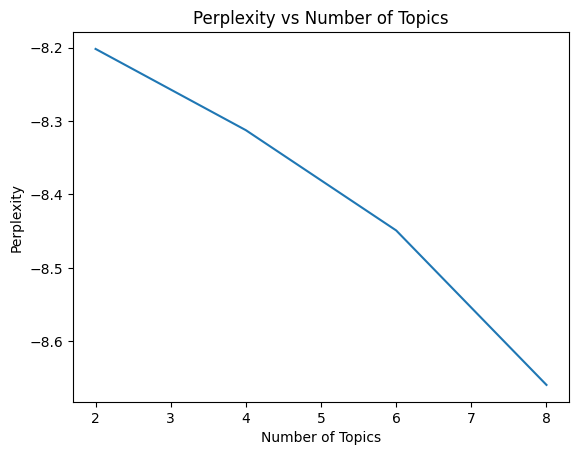

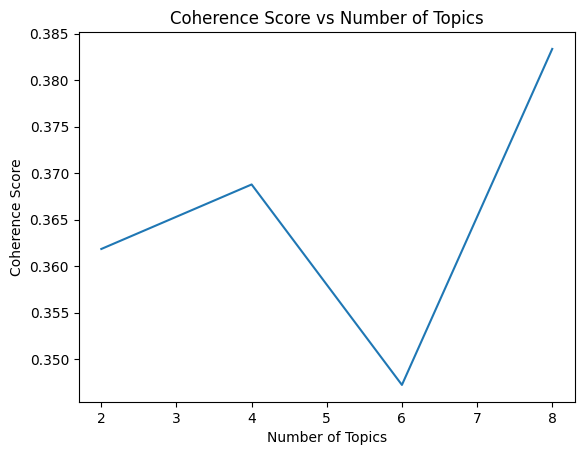

Optimal number of topics (using perplexity method): 8


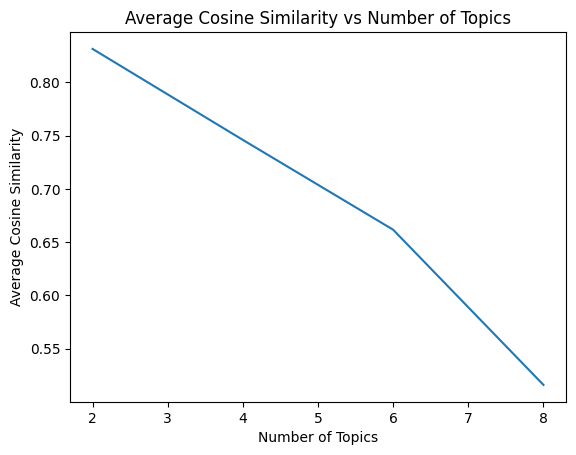

Optimal number of topics (using cosine similarity method): 8
Ultimate optimal number of topics : 8


In [22]:
# Set the file path for a text file.
file_path = "../data/review/processed/reviews_merged.txt"

# Get the optimal number of topics based on perplexity and cosine similarity.
best_num_topics_perplexity = get_optimal_topic_num_by_perplexity(file_path, num_topics_range, save_dir)
best_num_topics_similarity = get_optimal_topic_num_by_similarity(file_path, num_topics_range, save_dir)

# Print the ultimate optimal number of topics.
best_num_topics = int((best_num_topics_perplexity * weight_perplexity + best_num_topics_similarity * weight_similarity) / (weight_perplexity + weight_similarity))
print("Ultimate optimal number of topics :", best_num_topics)

### Improve " lda_topic_modeling " function, adjust parameters and add new functions

In [23]:
def lda_topic_modeling_with_assignment(file_path, num_topics, output_file):
    # Read the text file
    with open(file_path, "r", encoding="utf-8") as f:
        comments = [line.strip() for line in f]

    # Build the dictionary and bag-of-words model
    dictionary = Dictionary([comment.split() for comment in comments])
    print(dictionary)
    dictionary.filter_extremes(no_below=5, no_above=0.1)
    print(dictionary)
    
    # Convert comments into bag-of-words format
    corpus = [dictionary.doc2bow(comment.split()) for comment in comments]

    # Train the LDA model
    lda_model = LdaModel(corpus=corpus, 
                         num_topics=num_topics, 
                         id2word=dictionary, 
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    # Assign topics to comments
    topic_assignments = []
    for bow in corpus:
        doc_topics = lda_model.get_document_topics(bow)
        topic_assignments.append(max(doc_topics, key=lambda x: x[1])[0])

    # Print the top keywords for each topic
    for topic_id in range(num_topics):
        topic_words = lda_model.show_topic(topic_id, topn=30)
        print("Topic {}: {}".format(topic_id, ", ".join([word for word, prob in topic_words])))

    # Write the topic assignments to a CSV file
    with open(output_file, "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["review_splitting", "topic"])
        for comment, topic in zip(comments, topic_assignments):
            writer.writerow([comment, topic])
    print("Topic assignments saved in:", output_file)

    # Compute visualization data for the LDA model
    vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

    # Extract a portion of the file path as the filename
    filename = os.path.splitext(os.path.basename(file_path))[0]
    filename = "pyLDAvis/lda_visualization_{}.html".format(filename)

    # Save the visualization as an HTML file
    pyLDAvis.save_html(vis_data, filename)
    print("Visualization saved as:", filename)

In [24]:
file_path = "../data/review/processed/reviews_merged.txt"
output_file = "../data/review/analysis/topics/topic_assignments.csv"

lda_topic_modeling_with_assignment(file_path, best_num_topics, output_file)

Dictionary<30565 unique tokens: ['apm', '一圈', '一家', '不错', '云集']...>
Dictionary<6888 unique tokens: ['一圈', '一家', '云集', '交通', '人气']...>
Topic 0: 老, 积分, 小时候, 北京市, 地铁站, 区, 记忆, 营业, 年代, 张秉贵, 新, 工作人员, 开业, 变化, 大楼, 出, 态度, 时尚, 时代, 历史, 二层, 出门, 金街, 专柜, 这是, 坐落, 车位, 时, 全国, 亚洲
Topic 1: 东单, 东西, 最, 逛街, 适合, 新天地, 逛逛, 整体, 选择, 干净, 每次, 更, 顾客, 设施, 消费, 站, 休闲, 商业, 娱乐, 值得, 中, 新, 推荐, 这家, 繁华, 奢侈品, 舒服, 大型, 风格, 过年
Topic 2: 疫情, 吃饭, 停车, 店铺, 一些, 走, 不是, 步行街, 长安街, 不少, 东方广场, 很大, 餐厅, 过, 开, 一家, 发现, 少, 写字楼, 装修, 希望, 牌子, 高大, 好吃, 老牌, 周末, 高, 第一次, 楼上, 点
Topic 3: 说, 想, 好多, 朋友, 太, 时间, 免费, 带, 找, 期间, 超级, 孩子, 前, 完, 很少, 玩, 路过, ️, 进, 有个, 生活, 可爱, 平时, 开心, 进门, 爱, 展览, 两个, 不能, 算
Topic 4: 打卡, 拍照, 年, 回忆, 主题, 和平菓局, 感, 拍, 坐地铁, 综合性, 不到, 气氛, 快, 好看, 满满的, 小朋友, 布置, 回到, 新年, 知名品牌, 月, 儿时, 吸引, 感受, 中庭, 珠宝, 灯光, 童年, 十分, 鼠年
Topic 5: 不过, 有点, 做, 价格, 卖, 点评, 好像, 原因, 电影院, 开门, 中午, 转, 展, 不好, 扭蛋, 停车费, 外面, 元, 兑换, 卫生间, 记得, 真, 手机, 直达, A, 柜台, 显得, 便宜, 服务台, 购买
Topic 6: 东方新天地, 购物, 地铁, 大牌, 位置, 餐饮, 位于, 王府井大街, 高端, 交通, 停车场, 云集, 游客, 会员, 购物中心, 商业街, 中国, 商品, 地理位置, 面积, 便利, 建筑, 时尚,